In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
import pandas as pd
import nltk
from nltk.corpus import stopwords, words
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
import math

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import numpy as np
from gensim.models import Word2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [18]:
# Load review's csv's for both years and extract columns : comments-monthdf_reviews_april19 = pd.read_csv("gdrive/MyDrive/data/2019/april/reviews.csv")
df_reviews_april19 = pd.read_csv("gdrive/MyDrive/data/2019/april/reviews.csv")
df_reviews_april19['month'] = 'april'
df_reviews_february19 = pd.read_csv("gdrive/MyDrive/data/2019/febrouary/reviews.csv")
df_reviews_february19['month'] = 'february'
df_reviews_march19 = pd.read_csv("gdrive/MyDrive/data/2019/march/reviews.csv")
df_reviews_march19['month'] = 'march'

df_reviews_march23 = pd.read_csv("gdrive/MyDrive/data/2023/march/reviews.csv")
df_reviews_march23['month'] = 'march'
df_reviews_june23 = pd.read_csv("gdrive/MyDrive/data/2023/june/reviews.csv")
df_reviews_june23['month'] = 'june'
df_reviews_sept23 = pd.read_csv("gdrive/MyDrive/data/2023/september/reviews.csv")
df_reviews_sept23['month'] = 'september'

# Create an one-column dataframe for comments of 2019
df_comments_april19 = df_reviews_april19[['listing_id', 'comments', 'month']].copy()
df_comments_february19 = df_reviews_march19[['listing_id', 'comments', 'month']].copy()
df_comments_march19 = df_reviews_february19[['listing_id', 'comments', 'month']].copy()

# Create an one-column dataframe for comments of 2023
df_comments_june23 = df_reviews_june23[['listing_id', 'comments', 'month']].copy()
df_comments_march23 = df_reviews_march23[['listing_id', 'comments', 'month']].copy()
df_comments_sept23 = df_reviews_sept23[['listing_id', 'comments', 'month']].copy()

# df_comments = pd.concat([df_comments_april19, df_comments_march19, df_comments_february19, df_comments_june23, df_comments_march23, df_comments_sept23])
# df_comments.drop_duplicates(inplace=True)

df_comments19 = pd.concat([df_comments_april19, df_comments_march19, df_comments_february19])
df_comments19.drop_duplicates(inplace=True)
df_comments19.rename(columns={"listing_id" : "id"}, inplace=True)

df_comments23 = pd.concat([df_comments_june23, df_comments_march23, df_comments_sept23])
df_comments23.drop_duplicates(inplace=True)
df_comments23.rename(columns={"listing_id" : "id"}, inplace=True)

In [19]:
english_words = set(nltk.corpus.words.words())

# Method for cleaning the column comments
def clean_comment(comment):
    cleaned_comment = str(comment).lower()

    # Remove keep only english words
    tokens = nltk.wordpunct_tokenize(cleaned_comment)   # Split comment into tokens. Use as separators all the punctuation
    cleaned_comment = ' '.join(word for word in tokens if word in english_words)

    # Remove punctuation
    symbols_to_replace_with_space = "\\!\"-:/%+&\'*@_(),."
    for symbol in symbols_to_replace_with_space:
        cleaned_comment = cleaned_comment.replace(symbol, ' ')

    return cleaned_comment

# Pick a random chunk of 2019's data
df_comments19_sample = df_comments19.sample(800)
df_comments19_sample['comments'] = df_comments19_sample['comments'].apply(clean_comment)

# Same for 2023
df_comments23_sample = df_comments23.sample(800)
df_comments23_sample['comments'] = df_comments23_sample['comments'].apply(clean_comment)

# Remove all comments that after the cleaning became empty
df_cleaned_comments19 = df_comments19_sample[df_comments19_sample['comments'] != ''].copy()
df_cleaned_comments23 = df_comments23_sample[df_comments23_sample['comments'] != ''].copy()

In [20]:
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

# Method to apply sentimental analysis on a column of a dataframe
def analyze_sentiment(comment):
    result = sentiment_analysis(comment)[0]
    return result['label']

# Working for 2019
# Get the sentiment of each comment and rename the dataframe
df_sentiment19 = df_cleaned_comments19['comments'].apply(analyze_sentiment)
df_sentiment19.name = 'sentiment'

# Create a temporary dataframe with id's and concatenate all to one
df_comments_sentiment19 = pd.concat([df_cleaned_comments19, df_sentiment19], axis='columns').reset_index(drop=True)

# Working for 2023
df_sentiment23 = df_cleaned_comments23['comments'].apply(analyze_sentiment)
df_sentiment23.name = 'sentiment'

# Concatenate all comments and sentiments dataframes to one by keeping listing id
df_comments_sentiment23 = pd.concat([df_cleaned_comments23, df_sentiment23], axis='columns').reset_index(drop=True)

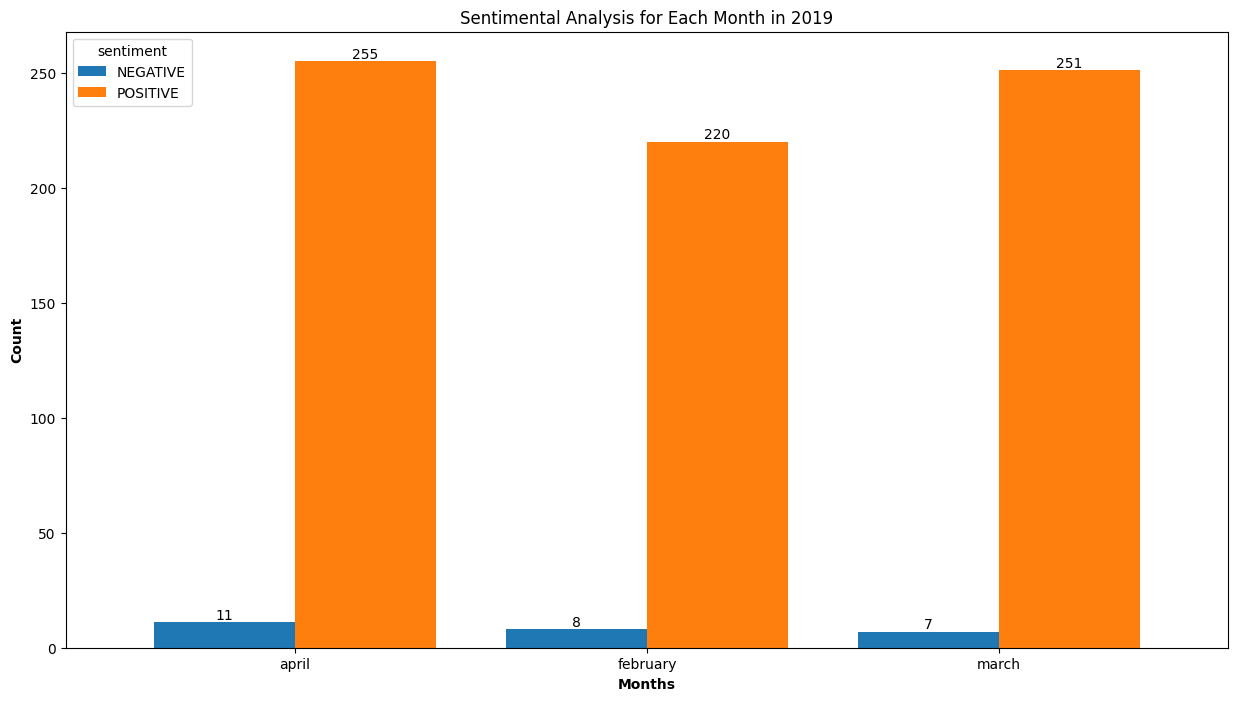

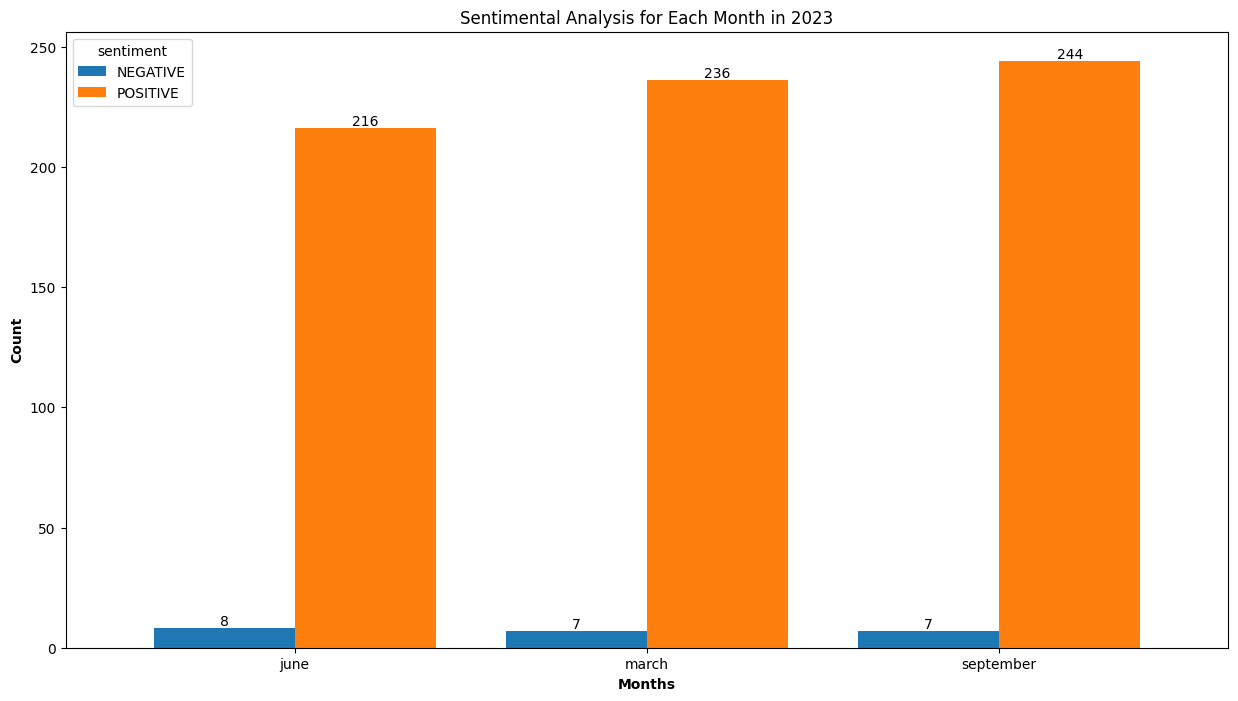

In [21]:
# Group the dataframe by month and plot sentimental analysis for each month of 2019
df_sentimental_analysis_per_month_19 = df_comments_sentiment19.groupby('month')['sentiment'].value_counts().reset_index().pivot(index='month', columns='sentiment', values='count')

plot1 = df_sentimental_analysis_per_month_19.plot(kind='bar', figsize=(15,8), width=0.8)
plot1.set_xlabel('Months', fontweight='bold')
plot1.set_ylabel('Count', fontweight='bold')
plot1.tick_params(axis='x', rotation=0)
plot1.set_title('Sentimental Analysis for Each Month in 2019')
plot1.bar_label(plot1.containers[0], fmt='%d')
plot1.bar_label(plot1.containers[1], fmt='%d')
plt.show()

# Same for 2023
df_sentimental_analysis_per_month_23 = df_comments_sentiment23.groupby('month')['sentiment'].value_counts().reset_index().pivot(index='month', columns='sentiment', values='count')

plot2 = df_sentimental_analysis_per_month_23.plot(kind='bar', figsize=(15,8), width=0.8)
plot2.set_xlabel('Months', fontweight='bold')
plot2.set_ylabel('Count', fontweight='bold')
plot2.tick_params(axis='x', rotation=0)
plot2.set_title('Sentimental Analysis for Each Month in 2023')
plot2.bar_label(plot2.containers[0], fmt='%d')
plot2.bar_label(plot2.containers[1], fmt='%d')
plt.show()

In [22]:
# Combine data from both years
df_combined = pd.concat([df_comments_sentiment19, df_comments_sentiment23]).reset_index(drop=True)

# Split into training and testing datasets (80-20)
train_df, test_df = train_test_split(df_combined, test_size=0.2, random_state=100, stratify=df_combined['sentiment'])

def get_w2vdf(df):
    w2v_df = pd.DataFrame(df["comments"]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df

# print(train_df)
w2v_df = get_w2vdf(train_df)
# w2v_df

train_df.to_csv("train.tsv", sep='\t', index=False)
test_df.to_csv("test.tsv", sep='\t', index=False)

In [23]:
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(train_df['comments'])
test_tfidf_matrix = vectorizer.transform(test_df['comments'])

with open("tfidf_features.pkl", 'wb') as f:
    pickle.dump((train_tfidf_matrix, test_tfidf_matrix, vectorizer), f)

In [24]:
# Train Word2Vec model

def train_w2v(w2v_df):
    w2v_model = Word2Vec(min_count=1,
                         window=5,
                         sentences=w2v_df,
                         vector_size=100,
                        #  alpha=0.03,
                        #  min_alpha=0.0007,
                         workers=4,
                         sg = 1)
    w2v_model.build_vocab(w2v_df, progress_per=10000)
    w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=40, report_delay=1) # epochs=model.epochs
    return w2v_model

w2v_model = train_w2v(w2v_df)

with open("word2vec_model.pkl", 'wb') as file:
    pickle.dump(w2v_model, file)

print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)}")

# word = 'host'

# Print the most similar words to the {word} above
# if word in w2v_model.wv:
#     print(f"Most similar words to '{word}': {w2v_model.wv.most_similar(word)}")
# else:
#     print(f"Word '{word}' not in vocabulary")

# Get the vector for a single comment
def get_vector(text):
    # Split the comment into words
    words = text.split()
    word_vectors = []

    # Collect vectors for words in the model's vocabulary
    for word in words:
        if word in w2v_model.wv:
            word_vectors.append(w2v_model.wv[word])

    # If there are any word vectors, return their average
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        # If no words are found in the w2v_model's vocabulary, return a zero vector
        return np.zeros(w2v_model.vector_size)

def get_word_embeddings(texts):
    # Apply get_vector to each text in the comments
    features = []
    for text in texts:
        features.append(get_vector(text))

    # Convert the list of features to an array for easier usage
    return np.array(features)

X_train_w2v = get_word_embeddings(train_df['comments'])
X_test_w2v = get_word_embeddings(test_df['comments'])

with open("word_embeddings.pkl", 'wb') as f:
    pickle.dump((X_train_w2v, X_test_w2v), f)

Vocabulary size: 2514


In [25]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, accuracy_score

# Load features
with open("tfidf_features.pkl", 'rb') as f:
    train_tfidf_matrix, test_tfidf_matrix, tfidf_vectorizer = pickle.load(f)

with open("word_embeddings.pkl", 'rb') as f:
    X_train_w2v, X_test_w2v = pickle.load(f)

y_train = train_df['sentiment']
y_test = test_df['sentiment']

# Choose classifiers
classifiers = {
    "SVM": SVC(), # kernel="rbf"
    "Random Forest": RandomForestClassifier(), # n_estimators=300
    "KNN": KNeighborsClassifier() # n_neighbors=9
}

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

# Custom scorers with zero_division parameter
precision_macro = make_scorer(precision_score, average='macro', zero_division=0)
recall_macro = make_scorer(recall_score, average='macro', zero_division=0)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)

# Function to evaluate classifiers using cross-validation
def evaluate_classifier(clf, x, y):
    scoring = {
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'accuracy': 'accuracy'
    }
    scores = cross_validate(clf, x, y, cv=10, scoring=scoring, return_train_score=False)
    return scores

# Train and evaluate using TF-IDFs
print("Evaluating classifiers with TF-IDF features\n")
for name, clf in classifiers.items():
    print(f"Evaluating {name}")
    scores = evaluate_classifier(clf, train_tfidf_matrix, y_train)
    print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
    print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
    print(f"F1-Score: {np.mean(scores['test_f1_macro']):.4f}")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
    print("\n")

# Train and evaluate using Word Embeddings
print("Evaluating classifiers with Word Embedding features\n")
for name, clf in classifiers.items():
    print(f"Evaluating {name}")
    scores = evaluate_classifier(clf, X_train_w2v, y_train)
    # Get a summary metric for each evaluation criterion
    print(f"Precision: {np.mean(scores['test_precision_macro']):.4f}")
    print(f"Recall: {np.mean(scores['test_recall_macro']):.4f}")
    print(f"F1-Score: {np.mean(scores['test_f1_macro']):.4f}")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f}")
    print("\n")

Evaluating classifiers with TF-IDF features

Evaluating SVM
Precision: 0.6859
Recall: 0.5708
F1-Score: 0.5929
Accuracy: 0.9720


Evaluating Random Forest
Precision: 0.6992
Recall: 0.5941
F1-Score: 0.6182
Accuracy: 0.9702


Evaluating KNN
Precision: 0.6613
Recall: 0.5811
F1-Score: 0.6020
Accuracy: 0.9686


Evaluating classifiers with Word Embedding features

Evaluating SVM
Precision: 0.6859
Recall: 0.5708
F1-Score: 0.5929
Accuracy: 0.9720


Evaluating Random Forest
Precision: 0.7117
Recall: 0.5945
F1-Score: 0.6226
Accuracy: 0.9711


Evaluating KNN
Precision: 0.6613
Recall: 0.5825
F1-Score: 0.6026
Accuracy: 0.9711




Στα παραπάνω αποτελέσματα μπορούμε να παρατηρήσουμε ότι συνήθως:

*   Ο RF έχει πιο υψηλό με μικρή διαφορά Precision, Recall, F1-Score και με λίγο μεγαλύτερη διαφορά Accuracy από τους SVM και KNN χρησιμοποιώντας τα Tf-idfs αλλά και τα WordEmbeddings



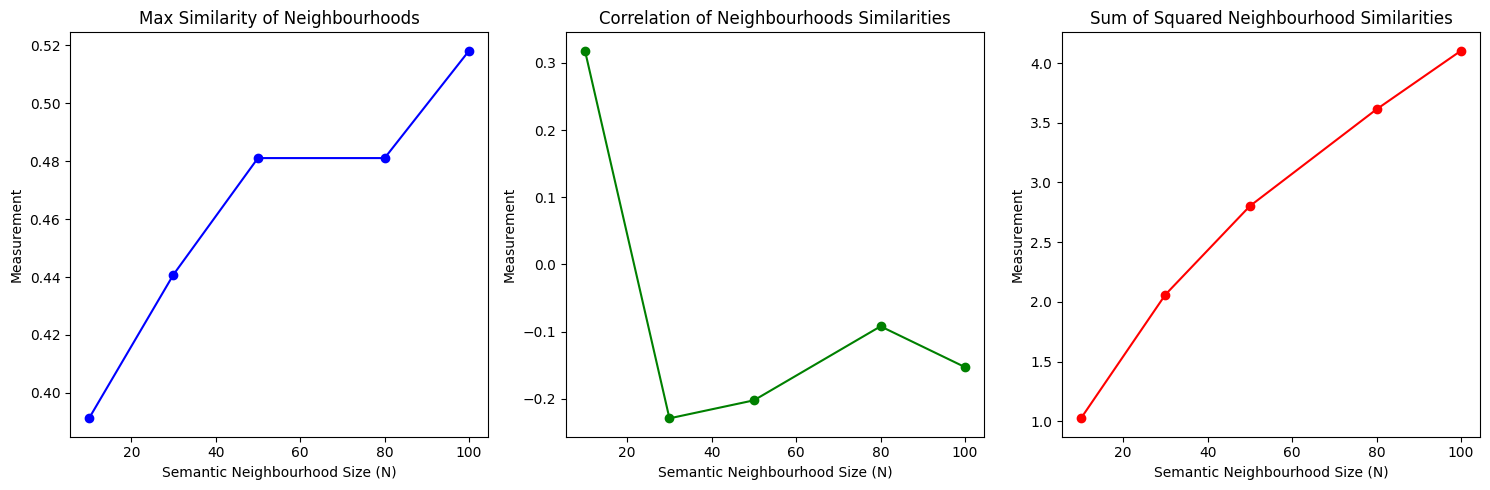

In [26]:
def words_similarity(model, word1, word2):
    return model.wv.similarity(word1, word2)

def get_semantic_neighbourhood(model, word, N=10):
    if word not in model.wv:
      print(f"Word '{word}' doesn't exist in Vocabulary!")
      return []

    return model.wv.most_similar(word, topn=N)

def max_similarity_of_neighbourhoods(model, word_i, word_j, N=10):
    semantic_neighbourhood_i = get_semantic_neighbourhood(model, word_i, N)
    semantic_neighbourhood_j = get_semantic_neighbourhood(model, word_j, N)

    # Extract first element of tupples which is the word
    semantic_neighbourhood_i_words = [tupple[0] for tupple in semantic_neighbourhood_i]
    semantic_neighbourhood_j_words = [tupple[0] for tupple in semantic_neighbourhood_j]

    # a_ij
    max_similarity_i = max([words_similarity(model, word_i, word_x) for word_x in semantic_neighbourhood_j_words])
    # a_ji
    max_similarity_j = max([words_similarity(model, word_j, word_y) for word_y in semantic_neighbourhood_i_words])

    return max(max_similarity_i, max_similarity_j)

def compute_correlation(vec1, vec2):
    return np.corrcoef(vec1, vec2)[0, 1]  # Pearson correlation coefficient


def correlation_of_neighbourhoods_similarities(model, word_i, word_j, N=10):
    semantic_neighbourhood_i = get_semantic_neighbourhood(model, word_i, N)
    semantic_neighbourhood_j = get_semantic_neighbourhood(model, word_j, N)

    # Extract first element of tupples which is the word
    semantic_neighbourhood_i_words = [tupple[0] for tupple in semantic_neighbourhood_i]
    semantic_neighbourhood_j_words = [tupple[0] for tupple in semantic_neighbourhood_j]

    similarities_word_i_with_neighbourhood_i = [words_similarity(model, word_i, word) for word in semantic_neighbourhood_i_words]
    similarities_word_i_with_neighbourhood_j = [words_similarity(model, word_i, word) for word in semantic_neighbourhood_j_words]

    beta_ij = compute_correlation(similarities_word_i_with_neighbourhood_i, similarities_word_i_with_neighbourhood_j)

    similarities_word_j_with_neighbourhood_i = [words_similarity(model, word_j, word) for word in semantic_neighbourhood_i_words]
    similarities_word_j_with_neighbourhood_j = [words_similarity(model, word_j, word) for word in semantic_neighbourhood_j_words]

    beta_ji = compute_correlation(similarities_word_j_with_neighbourhood_i, similarities_word_j_with_neighbourhood_j)

    return max(beta_ij, beta_ji)

def sum_of_squared_neighbourhood_similarities(model, word_i, word_j, N=10):
    semantic_neighbourhood_i = get_semantic_neighbourhood(model, word_i, N)
    semantic_neighbourhood_j = get_semantic_neighbourhood(model, word_j, N)

    # Extract first element of tupples which is the word
    semantic_neighbourhood_i_words = [tupple[0] for tupple in semantic_neighbourhood_i]
    semantic_neighbourhood_j_words = [tupple[0] for tupple in semantic_neighbourhood_j]

    squared_similarities_word_i_with_neighbourhood_j = [words_similarity(model, word_i, word)**2 for word in semantic_neighbourhood_j_words]
    squared_similarities_word_j_with_neighbourhood_i = [words_similarity(model, word_j, word)**2 for word in semantic_neighbourhood_i_words]

    E_words = math.sqrt((sum(squared_similarities_word_i_with_neighbourhood_j) + sum(squared_similarities_word_j_with_neighbourhood_i)))

    return E_words

# Define the similarity-metrics and words
similarity_metrics = ["Max Similarity of Neighbourhoods", "Correlation of Neighbourhoods Similarities", "Sum of Squared Neighbourhood Similarities"]
words = ['view', 'door']

# Define the factors N
Ns = [10, 30, 50, 80, 100]

# Initialize the data array
data = np.zeros((len(similarity_metrics), len(Ns)))

# Compute similarity-metrics for a couple of words 'view'-'door' for 5 different factors N
for j in range(len(Ns)):
    N = Ns[j]
    data[0, j] = max_similarity_of_neighbourhoods(w2v_model, words[0], words[1], N)
    data[1, j] = correlation_of_neighbourhoods_similarities(w2v_model, words[0], words[1], N)
    data[2, j] = sum_of_squared_neighbourhood_similarities(w2v_model, words[0], words[1], N)

# Plot the results
colors = ['blue', 'green', 'red']
fig, axs = plt.subplots(1, len(similarity_metrics), figsize=(15, 5))

for i in range(len(similarity_metrics)):
    axs[i].plot(Ns, data[i, :], marker='o', color=colors[i])
    axs[i].set_title(similarity_metrics[i])
    axs[i].set_xlabel("Semantic Neighbourhood Size (N)")
    axs[i].set_ylabel("Measurement")

plt.tight_layout()
plt.show()

The above graph shows the progression of metric values for different sizes of semantic neighborhoods.

Word 'kids' doesn't exist in Vocabulary!
[]


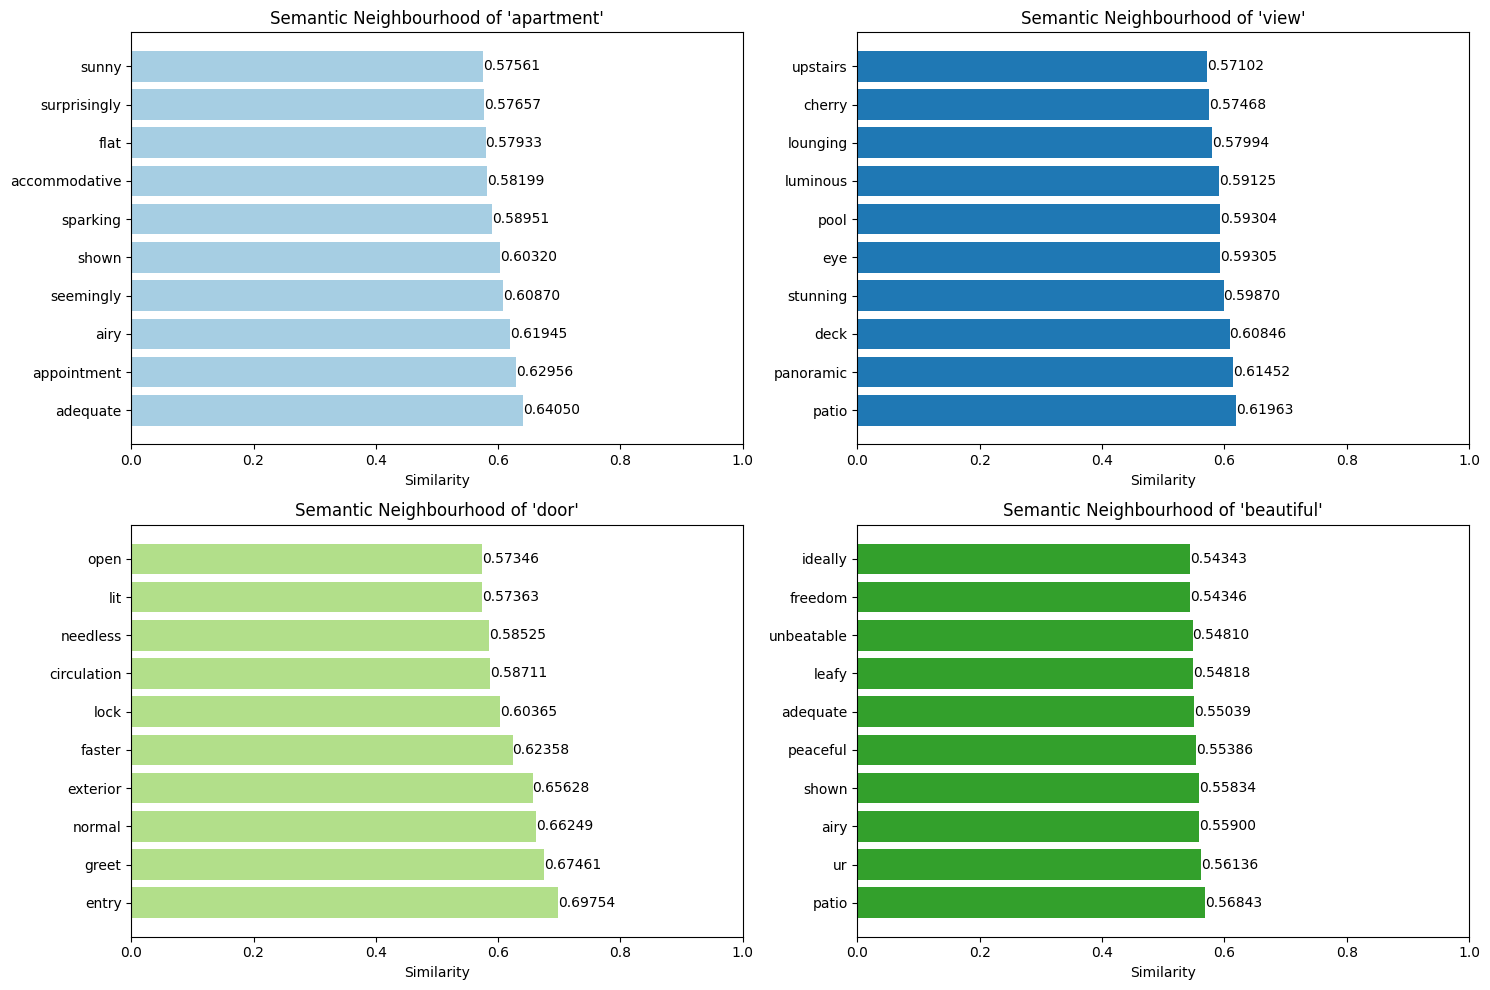

In [27]:
# Examples of Semantic Neighbourhoods
semantic_neighbourhoods = {
    'apartment': get_semantic_neighbourhood(w2v_model, 'apartment'),
    'view': get_semantic_neighbourhood(w2v_model, 'view'),
    'door': get_semantic_neighbourhood(w2v_model, 'door'),
    'beautiful': get_semantic_neighbourhood(w2v_model, 'beautiful'),
}
# Trying to get an print semantic neighbourhood for a word which doesn't exist in vocabulary --> Error Message
lock_semantic_neighbourhood = get_semantic_neighbourhood(w2v_model, 'kids')
print(lock_semantic_neighbourhood)

# Plot the semantic neighborhoods
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

words = list(semantic_neighbourhoods.keys())
for i, word in enumerate(words):
    ax = axs[i // int(len(semantic_neighbourhoods)/2), i % int(len(semantic_neighbourhoods)/2)]
    neighbours, scores = zip(*semantic_neighbourhoods[word])
    ax.barh(neighbours, scores, color=plt.cm.Paired.colors[i % 10])
    ax.set_title(f"Semantic Neighbourhood of '{word}'")
    ax.set_xlabel("Similarity")
    ax.set_xlim(0, 1)
    ax.bar_label(ax.containers[0], fmt='%0.5f')

plt.tight_layout()
plt.show()